Данные  

Игра содержит особое событие – ивент, для прохождения которого пользователи могут тратить деньги. Группа дизайнеров решила поменять вид окошка покупки ивентовых продуктов. Чтобы оценить результат нововведения, провели АБ тест, разделив пользователей на две группы: контрольную и тестовую (с окошком нового типа).

Задача  
Исследовать какая из АБ групп лучше себя показала.
Результаты предоставить в понятной для широкой аудитории форме, сопроводив по необходимости графиками/дашбордами/числами.
Колонки
1. AbGroup – имя АБ группы: Control/Test
2. user_id – id пользователя
3. time_stamp – день события
4. install_date – день установки приложения пользователем
5. event_name – техническое название события (InAppPurchase - в случае покупки за деньги, ResourceSpend в случае покупки за игровую валюту)
6. platform – платформа google / itunes
7. network_name – пользователь установил игру по переходу с рекламы (Paid) или нет (Organic)
8. country_name – страна пользователя
9. InGameTime – сколько всего пользователь провел в игре секунд
10. LastCompletedLevel – номер последнего пройденного уровня
11. avg_energy_amount – сколько в среднем энергии было у пользователя за день
12. revenue_on_event – ревеню, потраченное на покупку ивентовых продуктов
13. revenue_on_other_activities – ревеню, потраченное на остальные продукты, включая золото
14. gold_on_event – золото, потраченное на ивентный прогресс
15. gold_on_other_activities – золото, потраченное на другие продукты

In [346]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [347]:
# Настройки для графиков

plt.rcParams['legend.markerscale'] = 1.2
plt.rcParams['legend.handletextpad'] = 0.4
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['legend.borderpad'] = 0.4
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (12, 5)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=22)

## Разведочный анализ данных

In [348]:
df = pd.read_csv('test_task_product_analyst_2021_20210427.csv', parse_dates=['time_stamp', 'install_date'])
df.head()

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN


<AxesSubplot:title={'center':'Число потраченного золота'}>

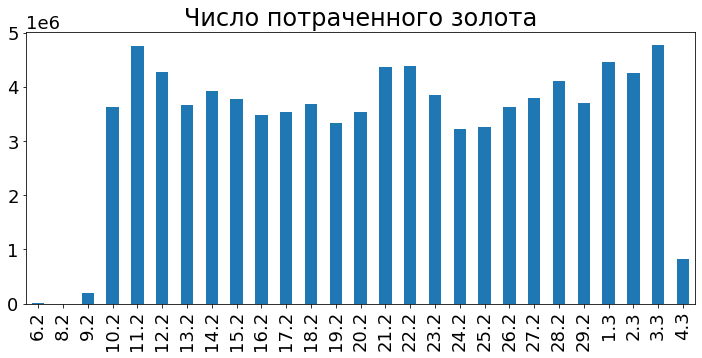

In [349]:
'''Так как в столбце 'event_name' фигурирует лишь ResourceSpend (покупки за игровую валюту), а в колонке 'revenue_on_event' 
везде указаны нули, при проведении теста будет руководствоваться тем, сколько потратили юзеры игровой валюты - золота
(колонка 'gold_on_event') В качестве метрики будем использовать ARPU - количество потраченного золота на юзера'''

df_revenue_check = df.groupby('time_stamp')[['gold_on_event']].sum().reset_index()
df_revenue_check['time_stamp'] = df_revenue_check['time_stamp'].apply(lambda value: f'{value.day}.{value.month}')
df_revenue_check.plot(x='time_stamp', kind='bar', title='Число потраченного золота', legend=False, xlabel='')

In [350]:
'''Как видно из графика, эксперимент скорее всего проводился с 10 февраля по 3 марта. Обрежем лишние концы и закрепим даты
начала и окончания эксперимента'''

begin_test = datetime(2020, 2, 10)
end_test = datetime(2020, 3, 3)
df_clean = df[df['time_stamp'].between(begin_test, end_test, inclusive='both')].drop_duplicates(['user_id', 'network_name'])

''' Не забываем у пользователей, которые не тратили золото во время ивента, заменить Nan на нули в колонке 'gold_on_event',
чтобы учесть их при расчете метрик и статистик'''

df_clean.loc[:, 'gold_on_event'].fillna(0, inplace=True)
df_clean.loc[:, 'gold_on_other_activities'].fillna(0, inplace=True)

In [351]:
'''Сплит юзеров для AB-теста уже был произведен в датасете, однако контрольная группа более чем в 4 раза больше, 
чем тестовая. Необходимо выравнить размеры групп. Отбор юзеров в контрольную группу будем пытаться выполнить так,
чтобы сложившиеся пропорции различных страт в экспериментальной группе были максимально сохранены в контрольной'''

df_clean.groupby('AbGroup')[['user_id']].nunique().head().reset_index()

,AbGroup,user_id
0,Control,86649
1,Test,21603


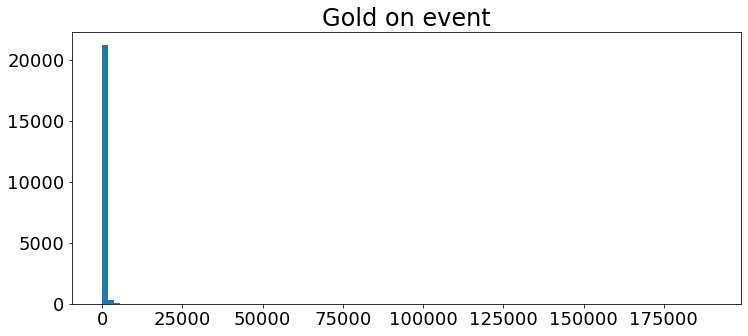

500.0

In [352]:
''' Видим, что большинство юзеров (более 96%) вообще не тратили золото во время ивента. Однако есть такие "киты", которые
тратили экстремальные суммы. Из-за этого дисперсия будет также большой. Будем искать метод ее снижения. Метод обработки
выбросов нам не подходит, так как именно "киты" и двигают экономику игры, это может исказить результаты экспериментов.
CUPED невозможно применить из-за отсутствия исторических данных. Попробуем применить постратификацию.'''

df_test = df_clean[df_clean['AbGroup'] == 'Test']
plt.title('Gold on event')
plt.hist(df_test['gold_on_event'].values, bins=100)
plt.show()
np.quantile(df_test['gold_on_event'].values, 0.967)

In [353]:
'''Доли юзеров по странам в тестовой группе'''

uniq_users_test = df_test['user_id'].nunique()
df_country_users = df_test.groupby('country_name')[['user_id']].nunique().reset_index()
df_country_users['user_id'] = round(df_country_users['user_id'] / uniq_users_test * 100, 2)
df_country_users = df_country_users.sort_values(by='user_id', ascending=False)
df_country_users.head(10)

,country_name,user_id
59,United Kingdom of Great Britain and Northern I...,27.43
20,Germany,24.72
18,France,21.02
8,Canada,13.09
53,Spain,11.32
14,Czech Republic,1.58
60,United States of America,0.10
26,Iran (Islamic Republic of),0.09
48,Reunion,0.06
22,Guadeloupe,0.05


In [354]:
'''Доли юзеров по каналам привлечения в тестовой группе'''

df_network_users = df_test.groupby('network_name')[['user_id']].nunique().reset_index()
df_network_users['user_id'] = round(df_network_users['user_id'] / uniq_users_test * 100, 2)
df_network_users = df_network_users.sort_values(by='user_id', ascending=False)
df_network_users.head(10)

,network_name,user_id
1,Paid,63.95
0,Organic,36.06


In [355]:
''' Для упрощения постратификации возьмем два параметра, согласно которому будем делим на страты: страна и канал привлечения. 
Можно было еще рассмотреть платформу, но все наши пользователи - владельцы айфонов.

В таблице мы видим распределение пользователей. 
Страта 1 - это игроки из Канады, которые перешли по рекламе
Страта 2 - это игроки из Канады, органический трафик
и т.д. '''

top_country = df_country_users[df_country_users['user_id'] > 10]['country_name'].values
df_test.loc[~df_clean['country_name'].isin(top_country), ['country_name']] = 'World'
df_test.loc[~df_clean['country_name'].isin(top_country), ['country_name']] = 'World'
pivot = pd.pivot_table(df_test,
                       index=['country_name'],
                       values=['user_id'],
                       columns=['network_name'],
                       aggfunc=['nunique'])
df_test_strat = pd.DataFrame({'Paid': pivot.iloc[:, 1].values, 'Organic': pivot.iloc[:, 0].values}, index=pivot.index.values)
df_test_strat

,Paid,Organic
Canada,1928,900
France,2802,1741
Germany,3095,2247
Spain,1616,830
United Kingdom of Great Britain and Northern Ireland,4059,1867
World,316,206


## Формирование контрольной группы и расчет метрики

In [439]:
''' Построим небольшую сплитилку для контрольной группы, чтобы соблюсти те же размеры страт, что и в экспериментальной группе'''

df_clean.loc[~df_clean['country_name'].isin(top_country), ['country_name']] = 'World'
users_control = np.array([])
for country in df_test_strat.index.values:
    for network in df_test_strat.columns:
        users_strat = np.unique(df_clean[
            (df_clean['AbGroup'] == 'Control') & (df_clean['country_name'] == country) & (df_clean['network_name'] == network)
        ]['user_id'].values)
        strat_size = df_test_strat.loc[country, network]
        select_users = np.random.choice(users_strat, strat_size, replace=False)
        users_control = np.concatenate((users_control, select_users), axis=None)
df_control = df_clean[df_clean['user_id'].isin(users_control)].reset_index()

In [440]:
''' Произведем разметку наших юзеров согласно стратам'''

n = 1
for country in df_test_strat.index.values:
    for network in df_test_strat.columns:
        df_control.loc[
            (df_control['country_name'] == country) & (df_control['network_name'] == network), 'strat'
        ] = n
        df_test.loc[
            (df_test['country_name'] == country) & (df_test['network_name'] == network), 'strat'
        ] = n
        n += 1

In [441]:
''' Рассчитаем ARPU для всех пользователей. В данном случае берем не выручку, а количество потраченного золота на ивент'''

df_control['strat'] = df_control['strat'].astype('int')
df_test['strat'] = df_test['strat'].astype('int')

df_rev_control = df_control.groupby(['user_id', 'strat'])['gold_on_event'].sum().reset_index()
df_rev_test = df_test.groupby(['user_id', 'strat'])[['gold_on_event']].sum().reset_index()

df_metrics_control = np.array([df_rev_control['gold_on_event'].values, df_rev_control['strat'].values]).T
df_metrics_test = np.array([df_rev_test['gold_on_event'].values, df_rev_test['strat'].values]).T

## Постратификация и процедура бутстрепа

In [448]:
def get_delta_mean_strat(metrics_strat_a_group, metrics_strat_b_group):
    """Применяет постстратификацию, возвращает разность стратифицированных средних.

    :param metrics_strat_a_group (np.ndarray): значения метрик и страт группы A.
        shape = (n, 2), первый столбец - метрики, второй столбец - страты.
    :param metrics_strat_b_group (np.ndarray): значения метрик и страт группы B.
        shape = (n, 2), первый столбец - метрики, второй столбец - страты.
    :return (float): разность стратифицированных средних
    """
    
    
    def calculate_stratified_mean(df, weights):
        """Вычисляет стратифицированное среднее.
    
        df - датафрейм с целевой метрикой и данными для стратификации
        weights - словарь - {название страты: вес страты}
    
        return: float, mean_strat
        """
        strat_mean = df.groupby('strat')['metric'].mean()
        df_means_weights = pd.merge(
            strat_mean,
            pd.Series(weights, name='weight'),
            how='inner',
            left_index=True,
            right_index=True
        )
        # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
        df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
        mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
        return mean_strat
    
    
    def calculate_statistics(a_group, b_group):
        """Вычисляет стратифицированные показатели для группы"""
        a_group = pd.DataFrame(a_group, columns=['metric', 'strat'])
        b_group = pd.DataFrame(b_group, columns=['metric', 'strat'])
        weights = pd.concat(
            [a_group['strat'], b_group['strat']], 
            ignore_index=True
        ).value_counts(normalize=True).to_dict()
        a_strat_mean = calculate_stratified_mean(a_group, weights)
        b_strat_mean = calculate_stratified_mean(b_group, weights)
        return a_strat_mean, b_strat_mean
    
    
    a_strat_mean, b_strat_mean= calculate_statistics(metrics_strat_a_group, metrics_strat_b_group)
    
    delta_mean_strat = b_strat_mean - a_strat_mean
    return b_strat_mean, a_strat_mean, delta_mean_strat

In [449]:
test_strat_mean, control_strat_mean, pe_metric = get_delta_mean_strat(df_metrics_control, df_metrics_test)
alpha = 0.05
print(f'Страт среднее в тестовой группе: {test_strat_mean:0.2f}')
print(f'Страт среднее в контрольной группе: {control_strat_mean:0.2f}')     

Страт среднее в тестовой группе: 92.34
Страт среднее в контрольной группе: 90.59


In [444]:
bs_point_estimates = []
group_control = df_rev_control['user_id'].values
group_test = df_rev_test['user_id'].values
for _ in range(10000):
    bs_control = np.random.choice(group_control, size=len(group_control), replace=True)
    bs_test = np.random.choice(group_test, size=len(group_test), replace=True)
    bs_metrics_control = np.array([
        df_rev_control[df_rev_control['user_id'].isin(bs_control)]['gold_on_event'].values, \
        df_rev_control[df_rev_control['user_id'].isin(bs_control)]['strat'].values
    ]).T
    bs_metrics_test = np.array([
        df_rev_test[df_rev_test['user_id'].isin(bs_test)]['gold_on_event'].values, \
        df_rev_test[df_rev_test['user_id'].isin(bs_test)]['strat'].values
    ]).T
    bs_point_estimate = get_delta_mean_strat(bs_metrics_control, bs_metrics_test)
    bs_point_estimates.append(bs_point_estimate)

In [445]:
def run_bootstrap(bootstrap_metrics, pe_metric, alpha):
    """Строит доверительный интервал и проверяет значимость отличий с помощью бутстрепа.
    
    :param bootstrap_metrics (np.array): множество значений статистики теста,
        посчитанные на бутстрепных выборках.
    :param pe_metric (float): значение статистики теста посчитанное по исходным данным.
    :param alpha (float): уровень значимости.
    :return left, right:
        left, right - левая и правая границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    
    return left, right

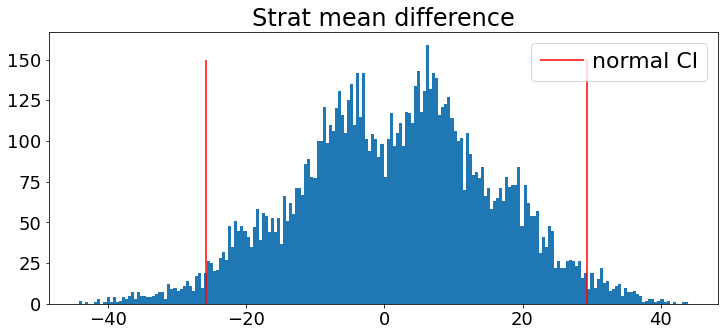

In [446]:
normal_ci = run_bootstrap(bs_point_estimates, pe_metric, alpha)

plt.title('Strat mean difference')
plt.hist(bs_point_estimates, bins=200)
plt.vlines(normal_ci, 0, 150, label='normal CI', color='red')
plt.legend()
plt.show()

**Вывод**: ноль входит внутрь доверительного интервала, а значит мы не можем отвергнуть нулевую гипотезу о том, что ARPU отличается статистически значимо.